In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import re
import json
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn import preprocessing
from scipy.stats import normaltest

%matplotlib inline

### Репозоторий на Github

https://github.com/kpalych/sf_data_since/tree/main/project_3

# Загрузка данных

In [2]:
data_train = pd.read_csv('../input/sf-booking/hotels_train.csv')
data_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [3]:
data_test = pd.read_csv('../input/sf-booking/hotels_test.csv')
data_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [4]:
submission = pd.read_csv('../input/sf-booking/submission.csv')
submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


# Глобальные константы и данные

In [5]:
min_review_date = None
max_review_date = None

lat_min = None
lat_max = None
lng_min = None
lng_max = None

# число зон "загрубления" широты и долготы
LAT_LNG_RANGES_COUNT = 8

# словари для хранения данных сентимента (метод SentimentIntensityAnalyzer)
positive_review_dict = {}
negative_review_dict = {}

# словари для хранения данных сентимента (методы TextBlob, Blobber)
tb_positive_review_dict = {}
tb_negative_review_dict = {}

Загрузка заранее вычисленных данных оценки сентимента (метод SentimentIntensityAnalyzer) из файлов

Код формирования этих файлов и описание методики находятся в файле kagle .\project_3\kagle\vader_lexicon_analizer.ipynb репозитория

In [6]:
with open('../input/sf-booking-sentiment-cahce/negative_review_dict.json', 'r') as in_file:
    negative_review_dict = json.load(in_file)
    
with open('../input/sf-booking-sentiment-cahce/positive_review_dict.json', 'r') as in_file:
    positive_review_dict = json.load(in_file)

Загрузка заранее вычисленных данных оценки сентимента (методы TextBlob, Blobber) из файлов

Код формирования этих файлов и описание методики находятся в файле kagle .\project_3\kagle\text_blob_analizer.ipynb репозитория

In [7]:
with open('../input/sfbookingtbsentimentcache/textblob_negative_review_dict.json', 'r') as in_file:
    tb_negative_review_dict = json.load(in_file)
    
with open('../input/sfbookingtbsentimentcache/textblob_positive_review_dict.json', 'r') as in_file:
    tb_positive_review_dict = json.load(in_file)

In [8]:
def tarnsform_data(df, tr_func, enable_drop_rows=True):
    result = df.copy()
    return tr_func(result, enable_drop_rows)

In [9]:
def before_transform_data(df_train, df_test=None, handle_fn=None):
    if handle_fn is not None:
        handle_fn(df_train, df_test)

Словарь с координатами для записей с отсутствующими значениями lat, lng

Код формирования данного словаря и описание методики в файле .\project_3\kagle\lat_lng_restore.ipynb репозитория

In [10]:
lat_lang_restore = {
    'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': {'lat': 48.20839138573059, 'lng': 16.353546796347032},
    'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': {'lat': 48.21562167042711, 'lng': 16.39096479275766},
    'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': {'lat': 48.219780629015546, 'lng': 16.358979659240067},
    '4 rue de la P pini re 8th arr 75008 Paris France': {'lat': 48.87203966411911, 'lng': 2.310877250558313},
    'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': {'lat': 48.19688597651822, 'lng': 16.388795420809718},
    'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': {'lat': 48.219780629015546, 'lng': 16.358979659240067},
    'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': {'lat': 48.2145071, 'lng': 16.2845042},
    'Bail n 4 6 Eixample 08010 Barcelona Spain': {'lat': 41.390913357347074, 'lng': 2.1722182519946807},
    'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': {'lat': 48.20336764322495, 'lng': 16.367175771189494},
    'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': {'lat': 48.219780629015546, 'lng': 16.358979659240067},
    '23 Rue Damr mont 18th arr 75018 Paris France': {'lat': 48.88860543984641, 'lng': 2.34017074274744},
    'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': {'lat': 48.20336764322495, 'lng': 16.367175771189494},
    'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': {'lat': 48.20839138573059, 'lng': 16.353546796347032},
    'Paragonstra e 1 11 Simmering 1110 Vienna Austria': {'lat': 48.176185590322575, 'lng': 16.41874150645161},
    '20 Rue De La Ga t 14th arr 75014 Paris France': {'lat': 48.83592243407595, 'lng': 2.3217339386329114},
    'Sep lveda 180 Eixample 08011 Barcelona Spain': {'lat': 41.38585424197342, 'lng': 2.1596960552147237},
    'Pau Clar s 122 Eixample 08009 Barcelona Spain': {'lat': 41.39390858262626, 'lng': 2.1672592153535355}
}

Данные для формирования категориальных признаков на основании поля tags

Код формирования этих данных и описание методики в файле .\project_3\kagle\convert_tags.ipynb репозитория

In [11]:
tags_patterns = {
    'purpose': [
        r'Leisure trip',
        r'Business trip'
    ],
    'group_size': [
        r'Solo traveler',
        r'Couple',
        r'Group',
        r'Family with young children',
        r'Family with older children'
    ],
    'rooms_count': [
        r'(Single Room)|(One Bedroom)',
        r'(Double Room)|(Twin Room)|(2 rooms)|(Twin Guest Room)|(Twin Hilton Guest Room)|(Double Hilton Guestroom)',
        r'(Triple Room)|(3 rooms)',
        r'Quadruple Room'
    ],
    'rooms_quality': [
        r'(Basic)|(Small)|(Compact)',
        r'(Economy)|(Standard)|(Classic)',
        r'(Club)|(Comfort)',
        r'(Superior)|(Executive)|(Suite)|(Junior Suite)',
        r'(Deluxe)|(Luxury)|(Premier)'
    ],
    'from_mobile': [
        r'Submitted from a mobile device'
    ],
    'options': [
        r'Cosy',
        r'(without Window)|(No Window)',
        r'With a pet',
        r'Non Smoking',
        r'(with Landmark View)|(with Winter Garden View)|(with Mountain View)|(with canal view)|(with Water View)|(with Garden View)|(with Iconic View)|(with View)|(with Internal View)|(City View)|(Stadium View)|(Bridge View)|(Street View)|(Courtyard View)|(with Sea View)|(with River View)|(with Park View)|(Eiffel Tower View)|(with State Opera View)|(with View of Big Ben)',
        r'(Spa Bath)|(Spa Access)|(with Spa Fitness Access)|(\sSpa\s)|(Pool)',
        r'(Balcony)|(Terrace)',
        r'(Sofa Bed)|(with Extra Bed)|(Double Bed)|(Two Double Beds)|(with Two Queen Beds)',
        r'(Queen)|(King)|(Royal)'
    ]
}

# Трансформация данных

In [12]:
def before_transform_handler_01(df_train, df_test):
    global min_review_date, max_review_date, lat_min, lat_max, lng_min, lng_max
    
    if df_test is not None:
        tmp_all = pd.concat([df_train, df_test], axis=0)
    else:
        tmp_all = df_train.copy()
    
    # Сохранение Min, Max значений поля review_date
    tmp_all['review_date'] = pd.to_datetime(tmp_all['review_date'], format='%m/%d/%Y')
    min_review_date = tmp_all['review_date'].min()
    max_review_date = tmp_all['review_date'].max()
    
    # Сохранение Min, Max значений поля lat
    lat_min = tmp_all['lat'].min()
    lat_max = tmp_all['lat'].max()

    # Сохранение Min, Max значений поля lng
    lng_min = tmp_all['lng'].min()
    lng_max = tmp_all['lng'].max()

In [13]:
def convert_days_str(s):
    match = re.search(r"(\d+)\s+day", s)
    if match is not None:
        days = int(match.group(1))          
        return days
    else:
        return 0
    
def get_nights_from_tags(tags):
    result = 0
    tags = json.loads(tags.replace("'", '"'))
    for tag in tags:
        match = re.search(r"(\d+)\s+night", tag)
        if match is not None:
            result = int(match.group(1))
        
    return result

def process_tags_feature(tags, f_name):
    global tags_patterns

    tags = json.loads(tags.replace("'", '"'))
    for tag in tags:
        cnt = 1
        for pattern in tags_patterns[f_name]:
            match = re.search(pattern, tag)
            if match is not None:
                return cnt
            cnt = cnt + 1
    
    return 0

def process_tags_options(tags, o_index):
    global tags_patterns

    tags = json.loads(tags.replace("'", '"'))
    for tag in tags:
        pattern = tags_patterns['options'][o_index-1]
        match = re.search(pattern, tag)
        if match is not None:
            return 1
    
    return 0

def lat_lng_convert_to_category(x, min_val, max_val, cnt):
    left_val = min_val
    delta = (max_val-min_val) / cnt

    if x < left_val:
        return 1

    for i in range(0, cnt):
        if x >= left_val and x < (left_val+delta):
            return i+1
        left_val = left_val + delta

    return cnt

def month_to_season_no(m):
    if m <= 2:
        return 1
    elif m > 2 and m <=5:
        return 2
    elif m > 5 and m <= 8:
        return 3
    elif m > 8 and m <= 11:
        return 4
    else:
        return 1

In [14]:
def tr_final(df, enable_drop_rows=True):
    if enable_drop_rows:
        # удаление дубликатов записей
        df = df.drop_duplicates()
    
    # восстановление пропущенных значений lat, lng
    for addr in lat_lang_restore:
        mask = (df['hotel_address'] == addr) & df['lat'].isna()
        df.loc[mask, 'lat'] = lat_lang_restore[addr]['lat']
        df.loc[mask, 'lng'] = lat_lang_restore[addr]['lng']
     
    # формирование категориальных признаков из широты и долготы
    # весь диапазон широты и долготы делится на LAT_LNG_RANGES_COUNT равных отрезков
    # и в полях lat_cat и lng_cat сохраняется номер отрезка в который попадает текущее значение
    df['lat_cat'] = df['lat'].apply(lambda x: lat_lng_convert_to_category(x, lat_min, lat_max, LAT_LNG_RANGES_COUNT))
    df['lng_cat'] = df['lng'].apply(lambda x: lat_lng_convert_to_category(x, lng_min, lng_max, LAT_LNG_RANGES_COUNT))
    df = pd.get_dummies(df, columns=['lat_cat', 'lng_cat'])
    df = df.drop(['lat', 'lng'], axis=1)

    # формирование группы категориальных признаков сентимента отзывов на основании заранее вычисленных значений (метод SentimentIntensityAnalyzer)

    df['positive_review_neg'] = 0.0
    df['positive_review_neu'] = 0.0
    df['positive_review_pos'] = 0.0
    df['positive_review_compound'] = 0.0

    df['negative_review_neg'] = 0.0
    df['negative_review_neu'] = 0.0
    df['negative_review_pos'] = 0.0
    df['negative_review_compound'] = 0.0
    
    
    df['positive_review_neg'] = df['positive_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (positive_review_dict[x] is None) else positive_review_dict[x]['neg'])
    df['positive_review_neu'] = df['positive_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (positive_review_dict[x] is None) else positive_review_dict[x]['neu'])
    df['positive_review_pos'] = df['positive_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (positive_review_dict[x] is None) else positive_review_dict[x]['pos'])
    df['positive_review_compound'] = df['positive_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (positive_review_dict[x] is None) else positive_review_dict[x]['compound'])

    df['negative_review_neg'] = df['negative_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (negative_review_dict[x] is None) else negative_review_dict[x]['neg'])
    df['negative_review_neu'] = df['negative_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (negative_review_dict[x] is None) else negative_review_dict[x]['neu'])
    df['negative_review_pos'] = df['negative_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (negative_review_dict[x] is None) else negative_review_dict[x]['pos'])
    df['negative_review_compound'] = df['negative_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (negative_review_dict[x] is None) else negative_review_dict[x]['compound'])
   
    # формирование группы категориальных признаков сентимента отзывов на основании заранее вычисленных значений (методы TextBlob, Blobber)

    df['positive_review_polarity'] = 0.0
    df['positive_review_subjectivity'] = 0.0
    df['positive_review_classification'] = 0.0
    df['positive_review_p_pos'] = 0.5
    df['positive_review_p_neg'] = 0.5

    df['negative_review_polarity'] = 0.0
    df['negative_review_subjectivity'] = 0.0
    df['negative_review_classification'] = 0.0
    df['negative_review_p_pos'] = 0.5
    df['negative_review_p_neg'] = 0.5
    
    df['positive_review_polarity'] = df['positive_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (tb_positive_review_dict[x] is None) else tb_positive_review_dict[x]['polarity'])
    df['positive_review_subjectivity'] = df['positive_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (tb_positive_review_dict[x] is None) else tb_positive_review_dict[x]['subjectivity'])
    df['positive_review_classification'] = df['positive_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (tb_positive_review_dict[x] is None) else tb_positive_review_dict[x]['classification'])
    df['positive_review_p_pos'] = df['positive_review'].apply(lambda x: 0.5 if (len(x.strip()) == 0) or (tb_positive_review_dict[x] is None) else tb_positive_review_dict[x]['p_pos'])
    df['positive_review_p_neg'] = df['positive_review'].apply(lambda x: 0.5 if (len(x.strip()) == 0) or (tb_positive_review_dict[x] is None) else tb_positive_review_dict[x]['p_neg'])

    df['negative_review_polarity'] = df['negative_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (tb_negative_review_dict[x] is None) else tb_negative_review_dict[x]['polarity'])
    df['negative_review_subjectivity'] = df['negative_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (tb_negative_review_dict[x] is None) else tb_negative_review_dict[x]['subjectivity'])
    df['negative_review_classification'] = df['negative_review'].apply(lambda x: 0.0 if (len(x.strip()) == 0) or (tb_negative_review_dict[x] is None) else tb_negative_review_dict[x]['classification'])
    df['negative_review_p_pos'] = df['negative_review'].apply(lambda x: 0.5 if (len(x.strip()) == 0) or (tb_negative_review_dict[x] is None) else tb_negative_review_dict[x]['p_pos'])
    df['negative_review_p_neg'] = df['negative_review'].apply(lambda x: 0.5 if (len(x.strip()) == 0) or (tb_negative_review_dict[x] is None) else tb_negative_review_dict[x]['p_neg'])

    # удаление текстовых признаков
    df = df.drop(['hotel_address', 'negative_review', 'positive_review'], axis=1)
       
    # кодирование поля hotel_name (BinaryEncoder)
    bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
    hotel_name_bin = bin_encoder.fit_transform(df['hotel_name'])
    df = pd.concat([df, hotel_name_bin], axis=1)
    df = df.drop(['hotel_name'], axis=1)
    
    # кодирование поля reviewer_nationality (BinaryEncoder)
    bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
    hotel_name_bin = bin_encoder.fit_transform(df['reviewer_nationality'])
    df = pd.concat([df, hotel_name_bin], axis=1)
    df = df.drop(['reviewer_nationality'], axis=1)

    # преобразование days_since_review в int
    df['days_since_review'] = df['days_since_review'].apply(convert_days_str)
    
    # формирование поля Число ночей (nights_from_tags) из тэгов
    df['nights_from_tags'] = df['tags'].apply(get_nights_from_tags)

    # формирование категориальных признаков на основании списка словарей tags_patterns, 
    # сформированных после ручного анализа списка тэгов

    df['purpose'] = 0
    df['group_size'] = 0
    df['rooms_count'] = 0
    df['rooms_quality'] = 0
    df['from_mobile'] = 0
    df['options_1'] = 0
    df['options_2'] = 0
    df['options_3'] = 0
    df['options_4'] = 0
    df['options_5'] = 0
    df['options_6'] = 0
    df['options_7'] = 0
    df['options_8'] = 0
    df['options_9'] = 0

    df['purpose'] = df['tags'].apply(lambda x: process_tags_feature(x, 'purpose'))
    df['group_size'] = df['tags'].apply(lambda x: process_tags_feature(x, 'group_size'))
    df['rooms_count'] = df['tags'].apply(lambda x: process_tags_feature(x, 'rooms_count'))
    df['rooms_quality'] = df['tags'].apply(lambda x: process_tags_feature(x, 'rooms_quality'))
    df['from_mobile'] = df['tags'].apply(lambda x: process_tags_feature(x, 'from_mobile'))

    df['options_1'] = df['tags'].apply(lambda x: process_tags_options(x, 1))
    df['options_2'] = df['tags'].apply(lambda x: process_tags_options(x, 2))
    df['options_3'] = df['tags'].apply(lambda x: process_tags_options(x, 3))
    df['options_4'] = df['tags'].apply(lambda x: process_tags_options(x, 4))
    df['options_5'] = df['tags'].apply(lambda x: process_tags_options(x, 5))
    df['options_6'] = df['tags'].apply(lambda x: process_tags_options(x, 6))
    df['options_7'] = df['tags'].apply(lambda x: process_tags_options(x, 7))
    df['options_8'] = df['tags'].apply(lambda x: process_tags_options(x, 8))
    df['options_9'] = df['tags'].apply(lambda x: process_tags_options(x, 9))

    # OHE кодирование признаков purpose, group_size, rooms_count, rooms_quality
    df = pd.get_dummies(df, columns=['purpose', 'group_size', 'rooms_count', 'rooms_quality'])
    
    # удаление исходных тэгов
    df = df.drop(['tags'], axis=1)
    
    # преобразование даты в DateTime
    df['review_date'] = pd.to_datetime(df['review_date'], format='%m/%d/%Y')

    # категориальный признак review_month - месяц из даты
    df['review_month'] = df['review_date'].dt.month.astype(int)
           
    bin_encoder = ce.BinaryEncoder(cols=['review_month'])
    review_month_bin = bin_encoder.fit_transform(df['review_month'])
    df = pd.concat([df, review_month_bin], axis=1)
    
    # категориальный признак review_season: 1-зима, 2-весна, 3-лето, 4-осень
    df['review_season'] = df['review_month'].apply(month_to_season_no)
    df = pd.get_dummies(df, columns=['review_season'])
    
    # удаление признаков review_date, review_month
    df = df.drop(['review_date', 'review_month'], axis=1)
    
    return df

### Параметры трансформации данных и обучения модели

In [15]:
SPLIT_FACTOR = 0.25
RANDOM_SEED = 42
ESTS_COUNT = 100
TARGET_COL_NAME = 'reviewer_score'
BEFORE_TRANSFORM_HANDLER = before_transform_handler_01
DATA_TRANSFORM_METHOD = tr_final

### Трансформация данных

In [16]:
before_transform_data(data_train, data_test, BEFORE_TRANSFORM_HANDLER)

In [17]:
# объединение учебных и тестовых данных в единый набор с сохранением признака типа данных
# (учебные, тестовые)

df_train = data_train.copy()
df_test = data_test.copy()

df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

df_all = df_test.append(df_train, sort=False).reset_index(drop=True)

C:\Users\k.osadchenko\AppData\Local\Temp\ipykernel_5564\460038197.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_test.append(df_train, sort=False).reset_index(drop=True)


In [18]:
df_all = tarnsform_data(df_all, DATA_TRANSFORM_METHOD, enable_drop_rows=False)

In [19]:
def is_data_normal(x, alpha=0.05):
    _, p = normaltest(x)
    
    if p < alpha:
        return False
    else:
        return True

In [20]:
def show_prop_stats(df_all, prop_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

    pl = sns.histplot(data=df_all, x=prop_name, bins=25, kde=True, ax=axes[0]);
    pl.set_title('Распределение {}'.format(prop_name));
    pl.set_ylabel('Частота')
    pl.grid()

    pl = sns.boxplot(data=df_all, x=prop_name, orient='h', width=0.9, ax=axes[1])
    pl.set_title('Распределение {}'.format(prop_name));
    pl.grid()

    print('{}: среднее: {} медиана: {} (распределение: {})'.format(
        prop_name, 
        round(df_all[prop_name].mean(), 4), 
        round(df_all[prop_name].median(), 4), 
        ('нормальное' if is_data_normal(df_all[prop_name]) else 'не нормальное')
    ))

### Диаграммы распределения числовых признаков

average_score: среднее: 8.3975 медиана: 8.4 (распределение: не нормальное)


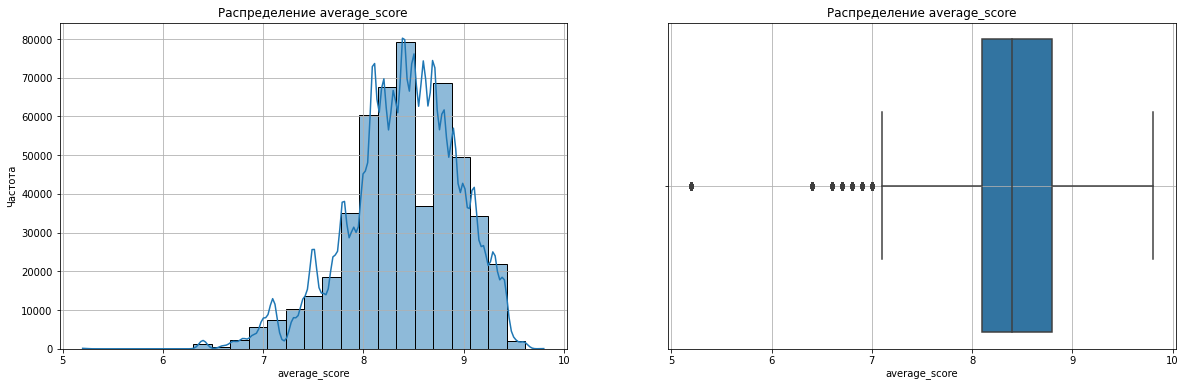

In [21]:
show_prop_stats(df_all, 'average_score')

review_total_negative_word_counts: среднее: 18.5395 медиана: 9.0 (распределение: не нормальное)


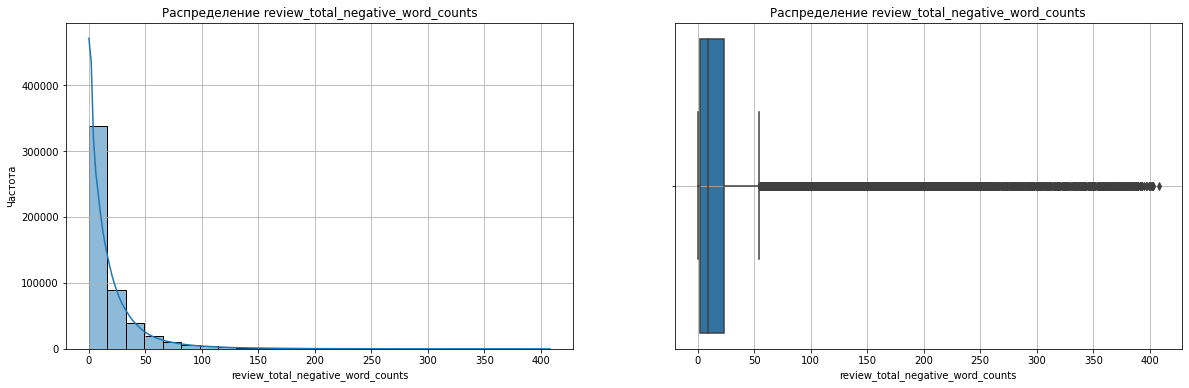

In [22]:
show_prop_stats(df_all, 'review_total_negative_word_counts')

total_number_of_reviews: среднее: 2743.7439 медиана: 2134.0 (распределение: не нормальное)


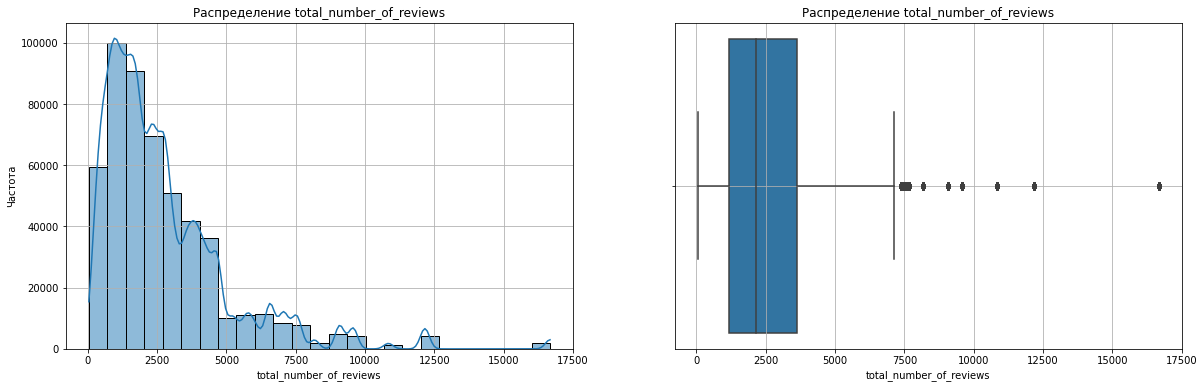

In [23]:
show_prop_stats(df_all, 'total_number_of_reviews')

review_total_positive_word_counts: среднее: 17.7765 медиана: 11.0 (распределение: не нормальное)


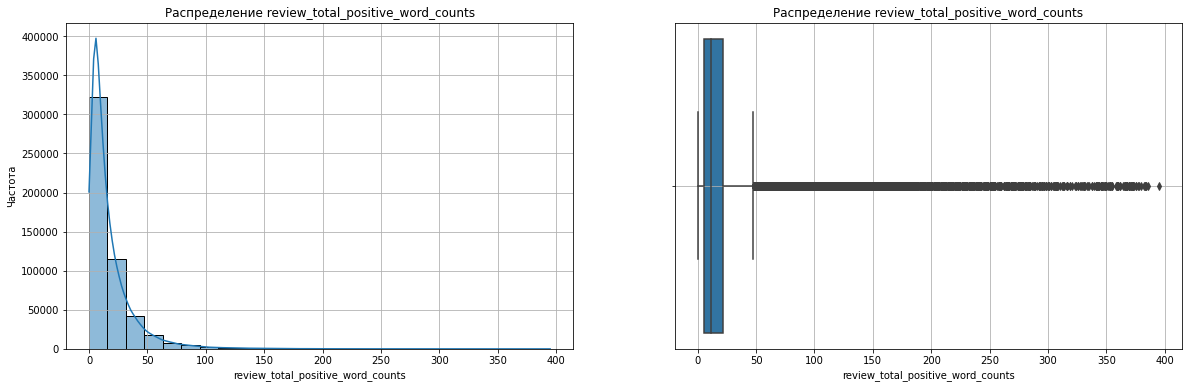

In [24]:
show_prop_stats(df_all, 'review_total_positive_word_counts')

total_number_of_reviews_reviewer_has_given: среднее: 7.166 медиана: 3.0 (распределение: не нормальное)


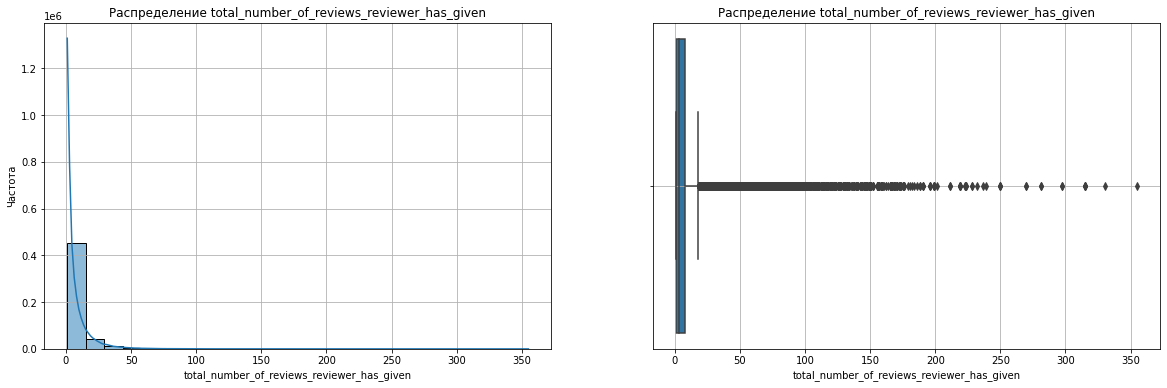

In [25]:
show_prop_stats(df_all, 'total_number_of_reviews_reviewer_has_given')

days_since_review: среднее: 354.4419 медиана: 353.0 (распределение: не нормальное)


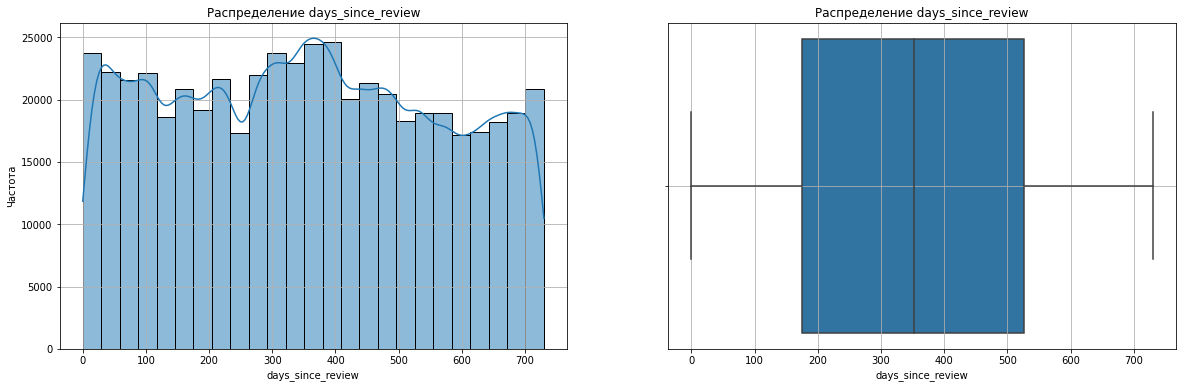

In [26]:
show_prop_stats(df_all, 'days_since_review')

nights_from_tags: среднее: 2.3614 медиана: 2.0 (распределение: не нормальное)


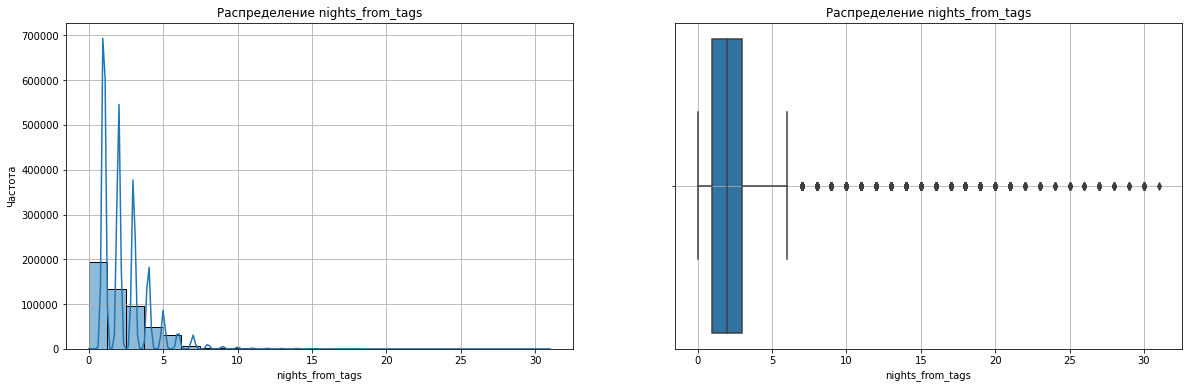

In [27]:
show_prop_stats(df_all, 'nights_from_tags')

In [28]:
minmax_cols = ['average_score', 'days_since_review', 'nights_from_tags']
robsc_cols = ['review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']

In [29]:
all_cols = list(df_all.columns)
all_cols.remove('reviewer_score')
all_cols.remove('sample')

number_cols = [
    'additional_number_of_scoring', 
    'average_score', 
    'review_total_negative_word_counts', 
    'total_number_of_reviews', 
    'review_total_positive_word_counts', 
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'nights_from_tags',
    'positive_review_neg',
    'positive_review_neu',
    'positive_review_pos',
    'positive_review_compound',
    'negative_review_neg',
    'negative_review_neu',
    'negative_review_pos',
    'negative_review_compound',
    'positive_review_polarity', 
    'positive_review_subjectivity', 
    'positive_review_classification', 
    'positive_review_p_pos', 
    'positive_review_p_neg', 
    'negative_review_polarity', 
    'negative_review_subjectivity', 
    'negative_review_classification', 
    'negative_review_p_pos', 
    'negative_review_p_neg'
]

### Матрица корреляции числовых признаков

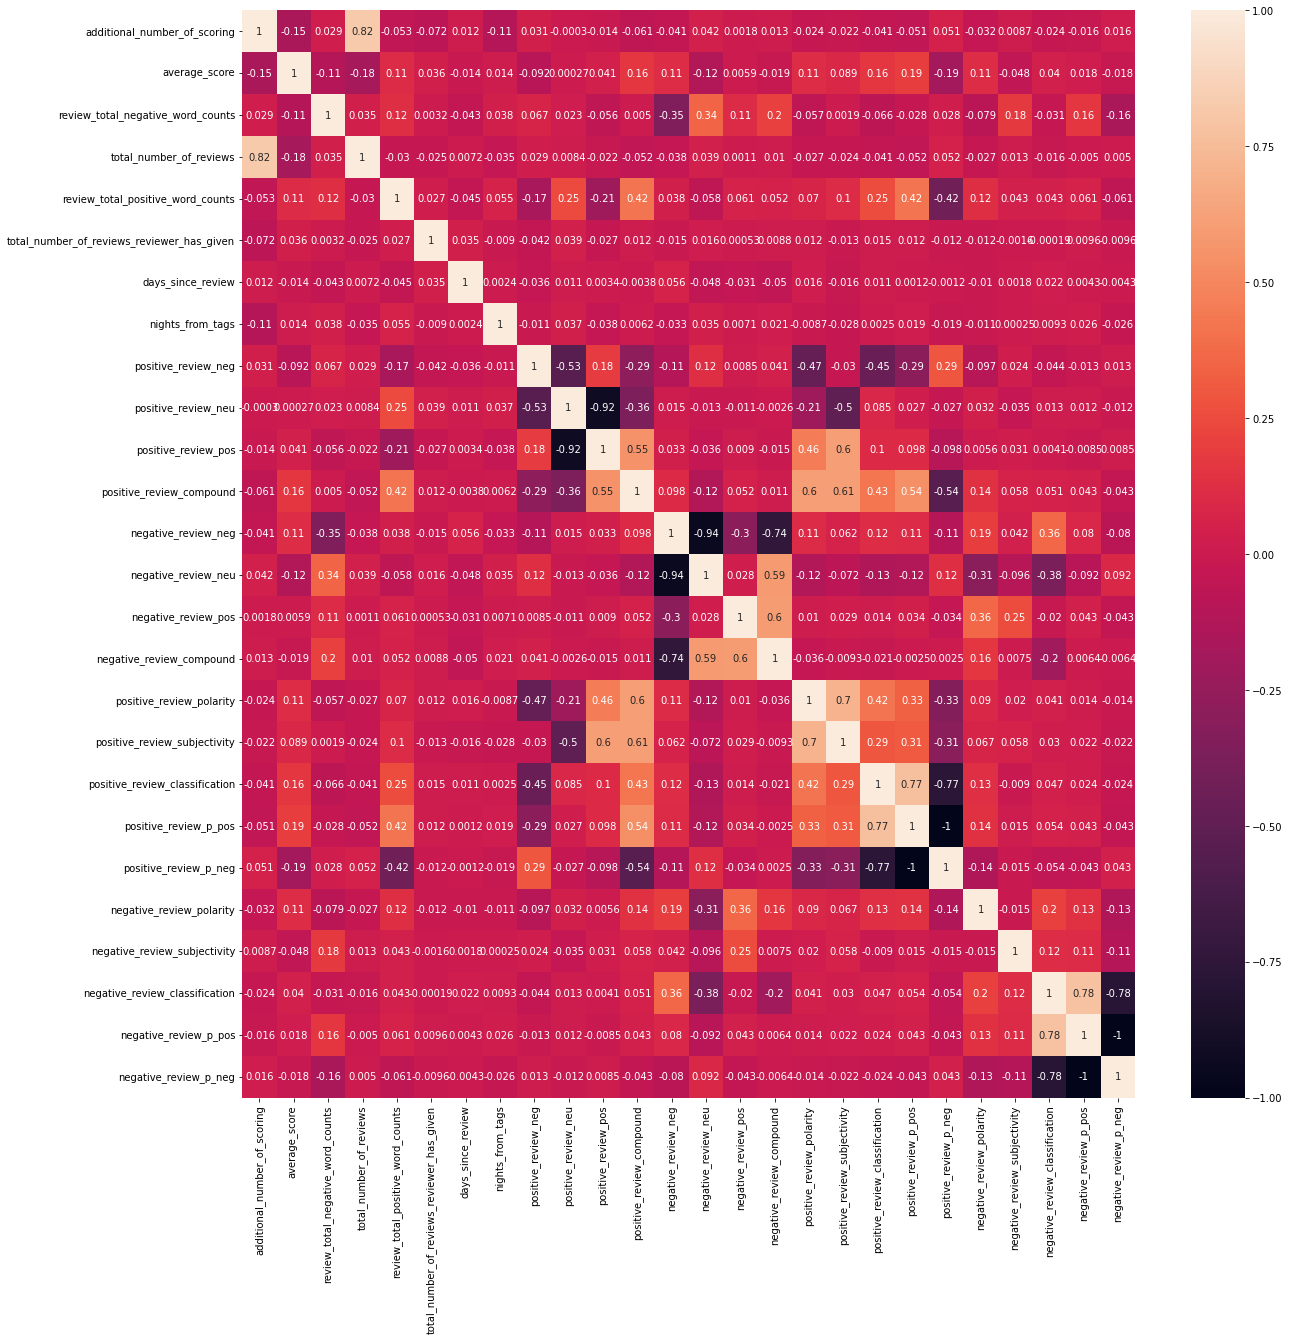

In [30]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_all[number_cols].corr(), annot = True);

In [31]:
cat_cols = list(set(all_cols).difference(set(number_cols)))

### Матрица корреляции категориальных признаков

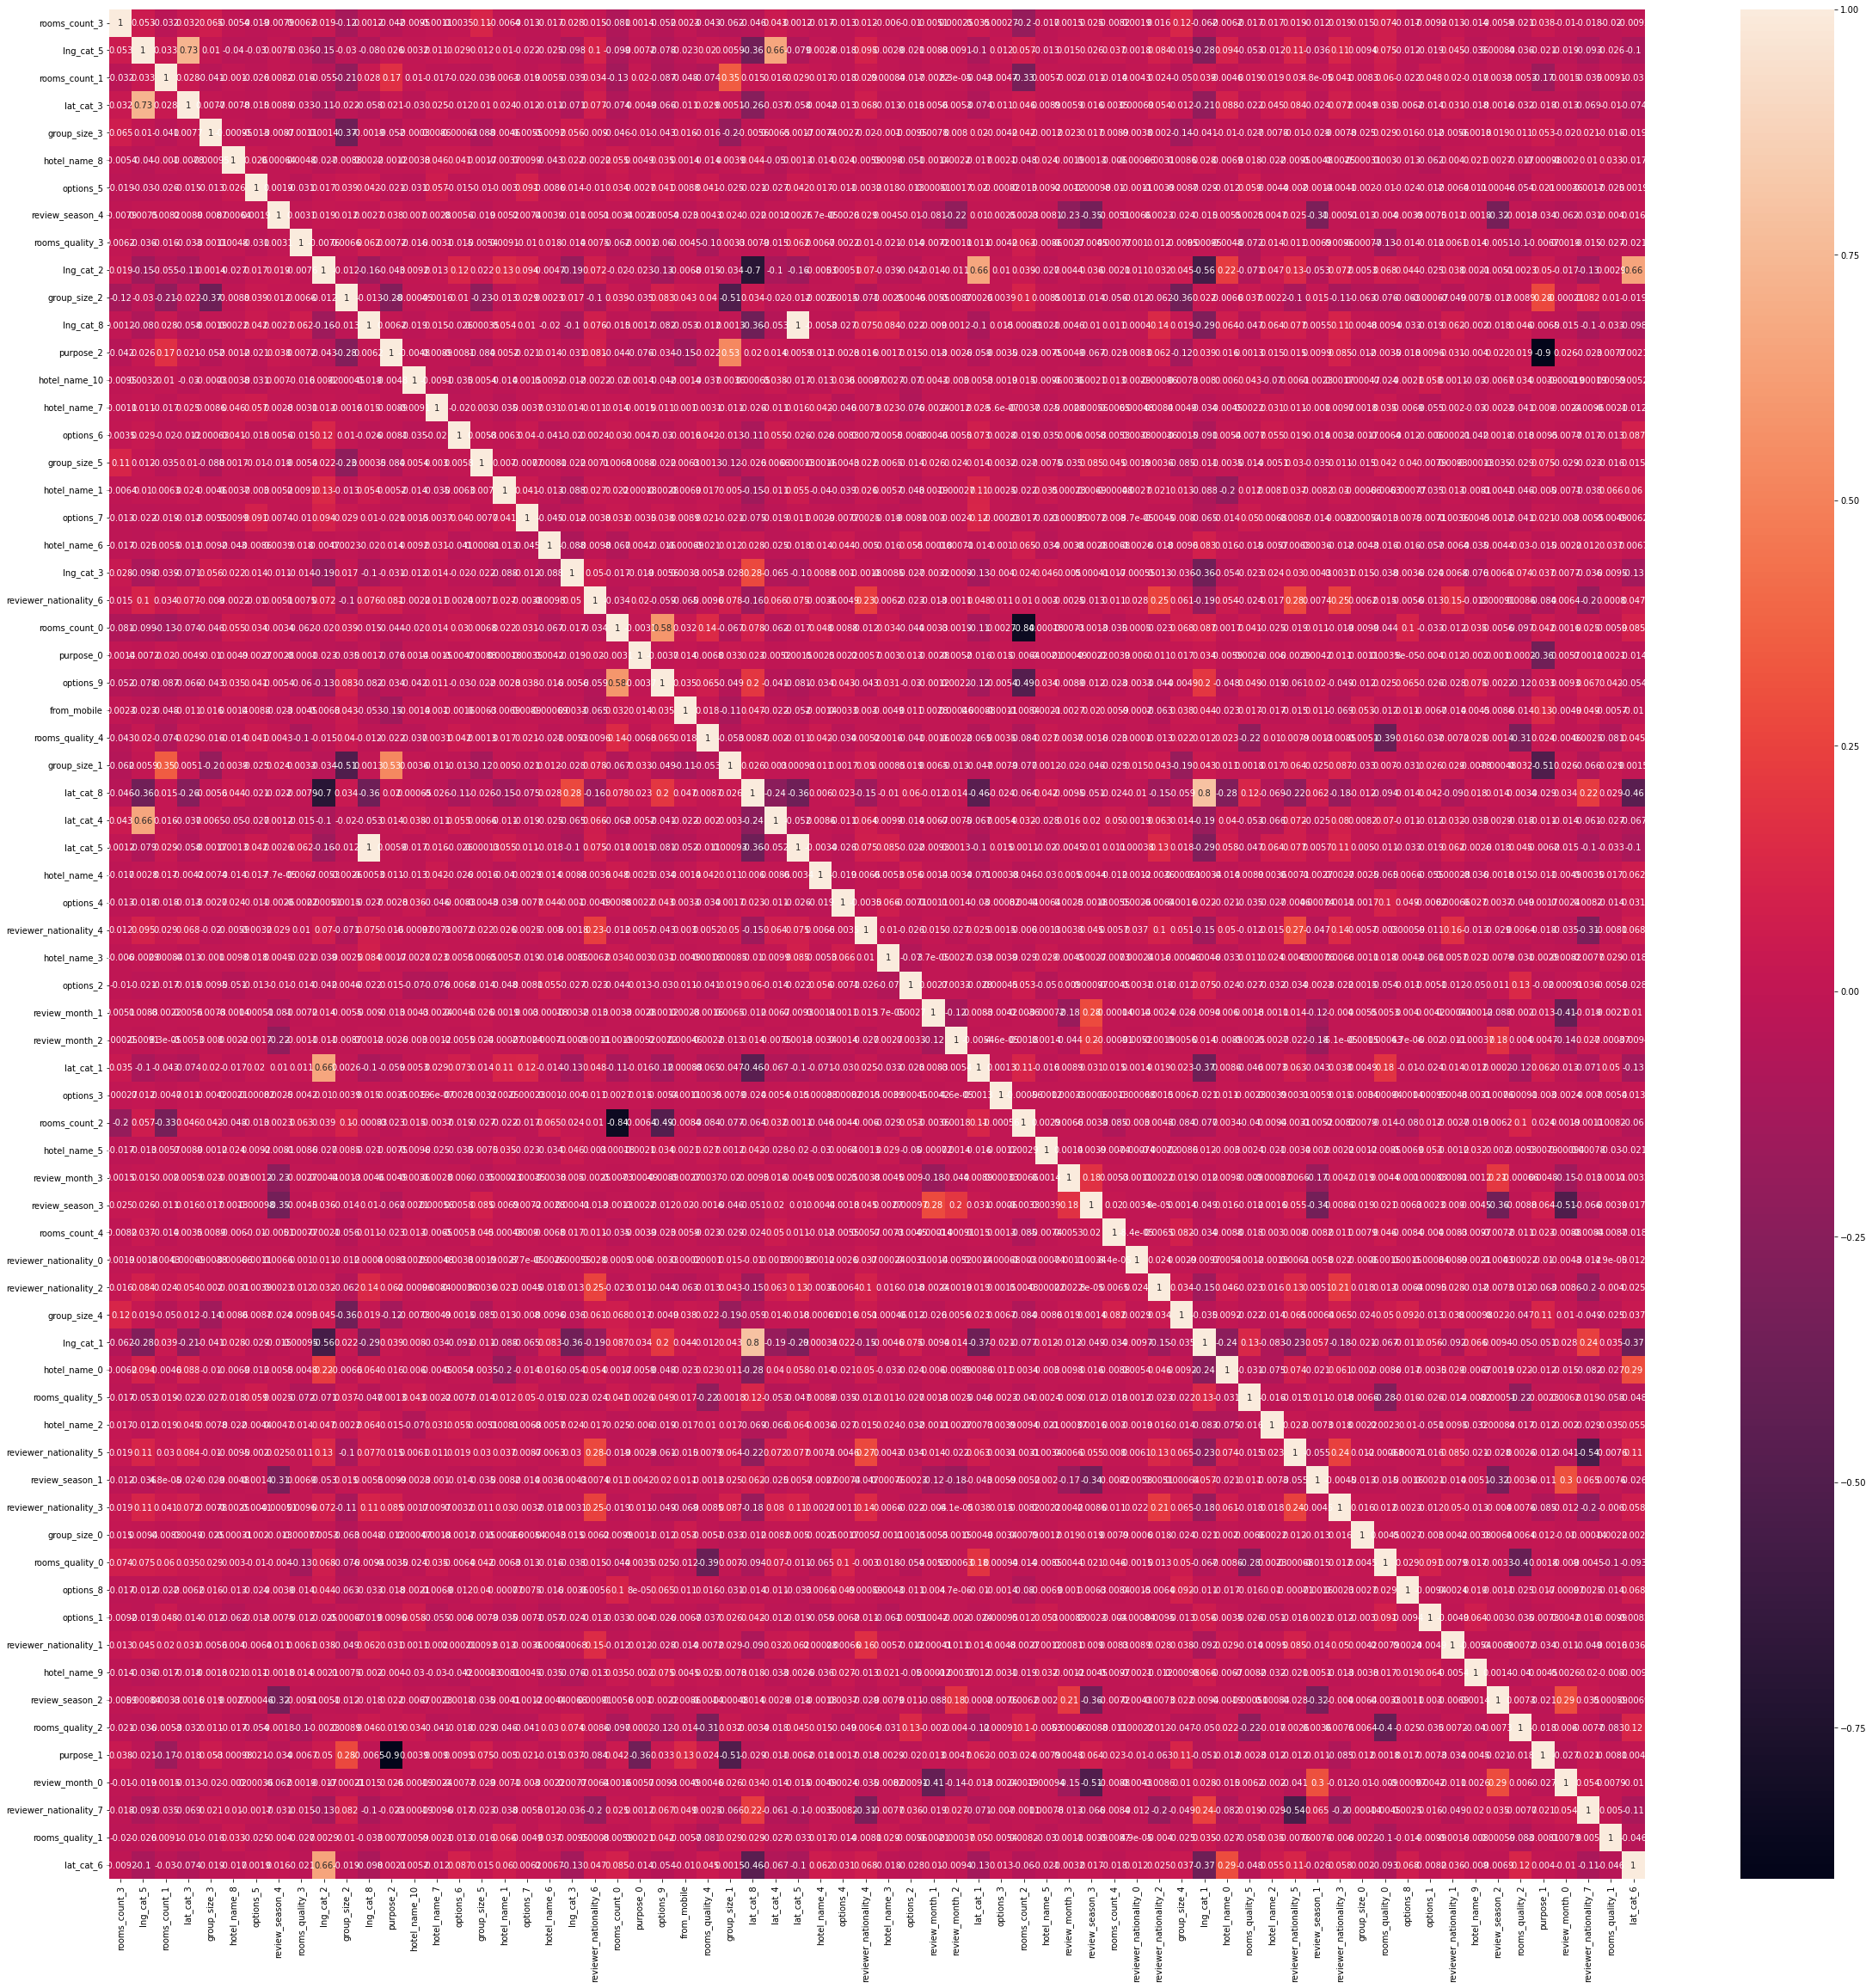

In [32]:
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(df_all[cat_cols].corr(method='spearman'), annot = True);

### Масштабирование числовых признаков
Для полей из списка minmax_cols используется метод MinMaxScaler

Из диаграм распределения данных у признаков из списка robsc_cols можно предположить, что наилучшим методом масштабироания будет RobustScaler.

Однако экспериментальная проверка показала, что метод MinMaxScaler дает лучший результат.

In [33]:
mm_scaler = preprocessing.MinMaxScaler()
df_all[minmax_cols] = mm_scaler.fit_transform(df_all[minmax_cols])

In [34]:
#r_scaler = preprocessing.RobustScaler()
#df_all[robsc_cols] = r_scaler.fit_transform(df_all[robsc_cols])

mm_scaler = preprocessing.MinMaxScaler()
df_all[robsc_cols] = mm_scaler.fit_transform(df_all[robsc_cols])

In [35]:
df_all.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,lat_cat_1,...,rooms_quality_4,rooms_quality_5,review_month_0,review_month_1,review_month_2,review_month_3,review_season_1,review_season_2,review_season_3,review_season_4
0,904,0.630435,0.127451,1.000000,0.156962,0.000000,0.017808,0,0.0,0,...,0,0,0,0,0,1,0,0,1,0
1,612,0.739130,0.024510,0.299212,0.000000,0.016949,0.320548,0,0.0,0,...,0,0,0,0,1,0,1,0,0,0
2,46,0.673913,0.007353,0.018524,0.012658,0.039548,0.843836,0,0.0,1,...,0,0,0,0,1,1,0,0,0,1
3,241,0.847826,0.000000,0.090215,0.068354,0.022599,0.898630,0,0.0,0,...,1,0,0,1,0,0,0,0,0,1
4,834,0.847826,0.000000,0.279305,0.017722,0.002825,0.608219,0,0.0,0,...,0,0,0,1,0,1,0,1,0,0


In [36]:
df_train_tmp = df_all.query('sample == 1').drop(['sample'], axis=1)

## Оценка вклада отдельных признаков

In [37]:
X = df_train_tmp.drop([TARGET_COL_NAME], axis = 1)  
y = df_train_tmp[TARGET_COL_NAME] 

### Категориальные признаки

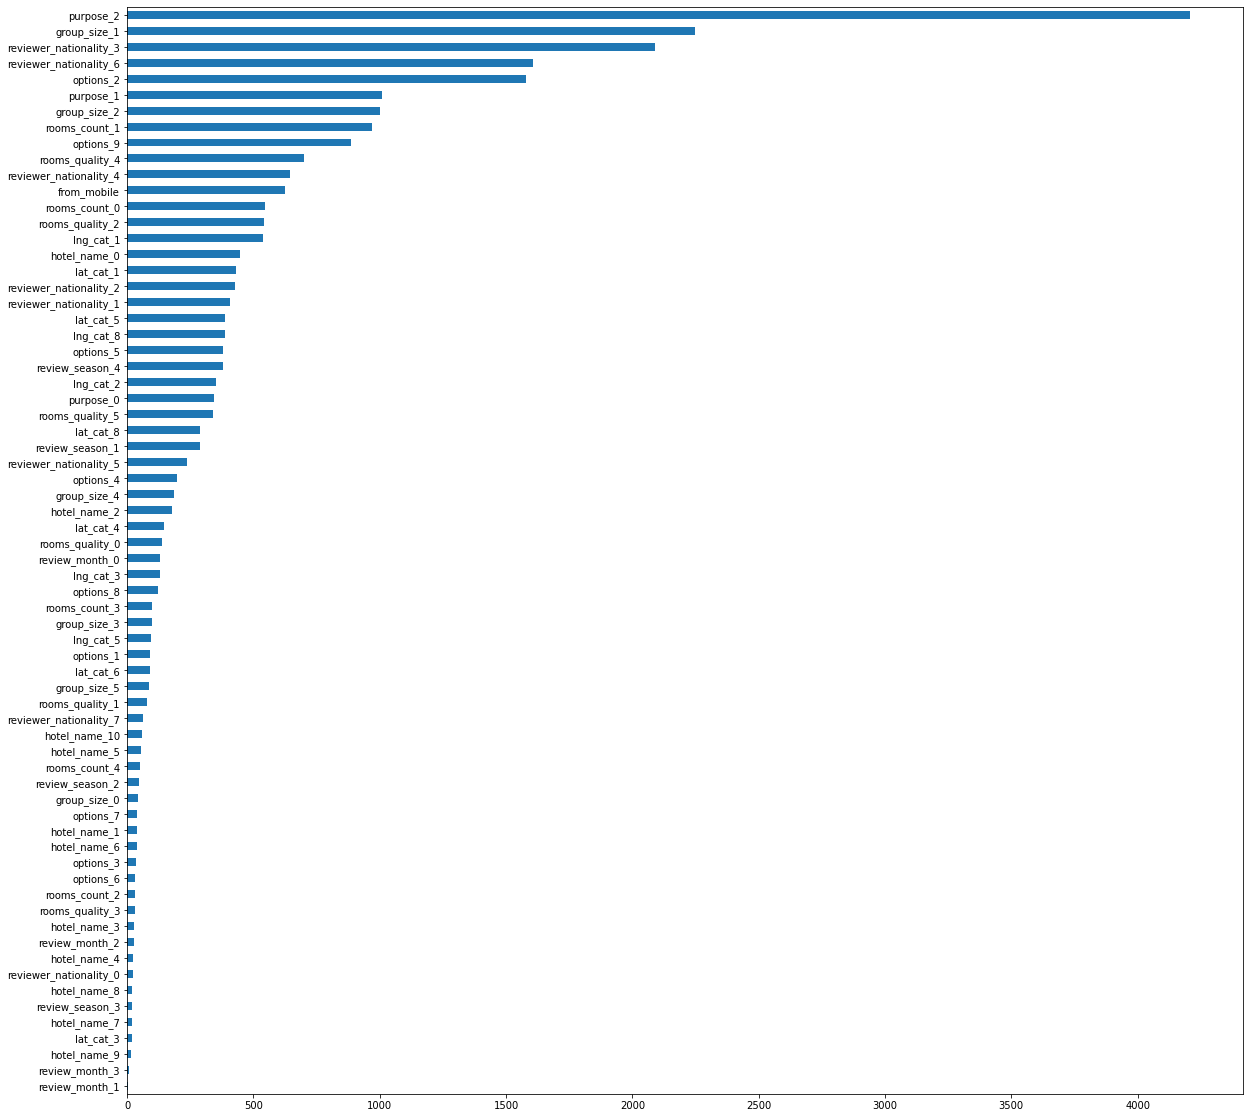

In [38]:
y_ = y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y_)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize=(20, 20));

### Числовые признаки

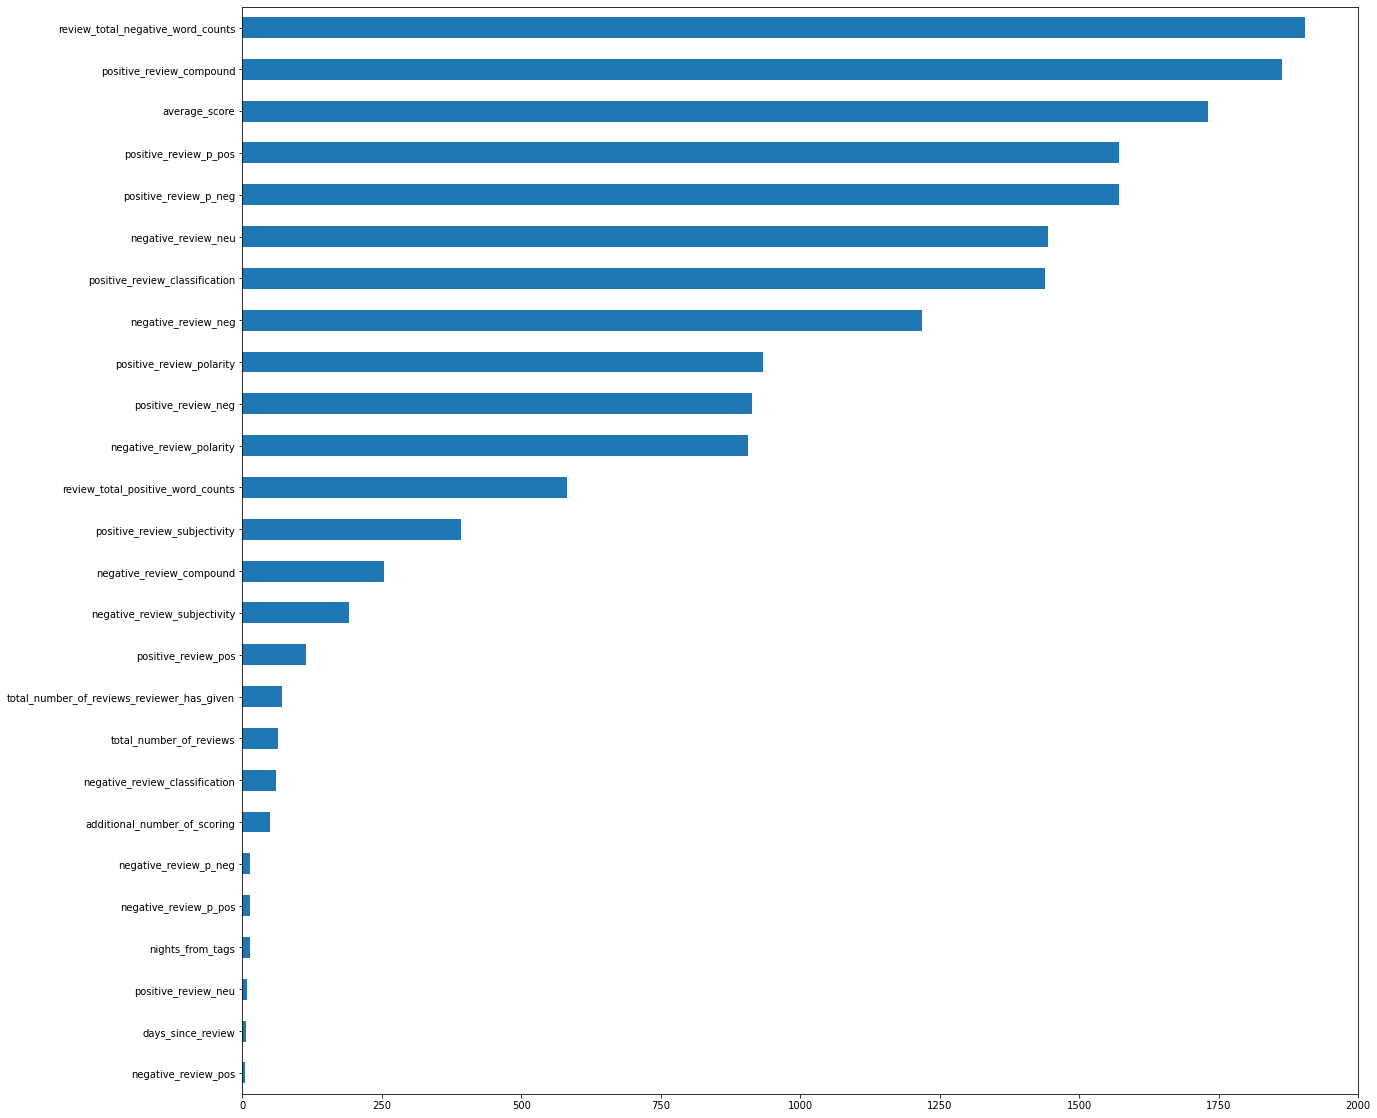

In [39]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[number_cols], y)[0], index=number_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind='barh', figsize=(20, 20));

### Удаление признаков
На основании матриц корреляции, диаграм значимости признаков и экспериментов были вабраны поля, которые необходимо удалить из набора данных перед обучением модели

In [40]:
cols_to_drop = ['additional_number_of_scoring', 'positive_review_neu', 'negative_review_p_pos', 'positive_review_p_neg']
df_all = df_all.drop(cols_to_drop, axis=1)

### Подготовка данных для обучения модели

In [41]:
df_train = df_all.query('sample == 1').drop(['sample'], axis=1)
df_test = df_all.query('sample == 0').drop(['sample'], axis=1)
df_test = df_test.drop(['reviewer_score'], axis=1)

### Удаление полных дубликатов записей из учебного набора данных

In [42]:
df_train.shape

(386803, 91)

In [43]:
df_train = df_train.drop_duplicates()

In [44]:
df_train.shape

(386494, 91)

### Формирование матрицы X и вектора y для обучения модели

In [45]:
X = df_train.drop([TARGET_COL_NAME], axis = 1)  
y = df_train[TARGET_COL_NAME]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_FACTOR, random_state=RANDOM_SEED)

### Обучение модели

In [47]:
regr = RandomForestRegressor(n_estimators=ESTS_COUNT, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
regr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.5min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

### Предсказание на тестовых данных

In [48]:
y_pred = regr.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.3s finished


### Оценка качества модели по MAPE

In [49]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12044326509852246


### Формирование данных для отправки в Kaggle

In [50]:
submission_pred = regr.predict(df_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.9s finished


In [51]:
submission['reviewer_score'] = submission_pred
submission.head()

,reviewer_score,id
0,8.662,488440
1,7.603,274649
2,8.345,374688
3,9.642,404352
4,9.386,451596


In [52]:
submission.to_csv('submission_final.csv', index=False)